<h1>Final Project Tutorial - Taeyoon Kim, Victor Chang, Blue Keleher</h1>

## Introduction
In this tutorial, you will apply our data science skills to see how well you can classify a mushroom by its edibility. We will be using [mushroom data](https://www.kaggle.com/uciml/mushroom-classification) provided by UC Irvine to train our machine learning algorithms, and rely heavily on the python toolkit [scikit-learn](#http://scikit-learn.org/stable/). The tutorial will walk through the process of creating decision trees and support vector machines for a binary classification given categorical features, which often makes analysis slightly more difficult.

While mushrooms are not often life-threatening or life-changing, these supervised learning algorithms are applicable to almost any classification problem. And, of course, this isn't to say that mushrooms aren't *ever* life-changing.

**Inside this tutorial:**
- [Data Preparation: Collection and Processing](#I.-Data-Preparation:-Collection-and-Processing)
- [Exploratory Data Analysis](#II.-Exploratory-Data-Analysis)
- [Machine Learning](#III.-Machine-Learning)
    - [Decision Trees](#Decision-Trees)
    - [K-Fold Cross Validation](#K-Fold-Cross-Validation)
    - [Support Vector Machines](#Support-Vector-Machines)
- [Conclusion](#IV.-Conclusion)

<h2>Getting Started...</h2>
<p>Before you begin, you will need to install a couple things. First, make sure you have <a href='https://docs.continuum.io/anaconda/install'>Anaconda</a> installed on your computer. Then, use Anaconda's package manager to install 'pandas', 'numpy', 'matplotlib', 'graphviz', and 'sklearn'.</p>
<p>Also, download the mushroom dataset <a href='https://www.kaggle.com/uciml/mushroom-classification'>here</a>.</p>
<p>After setting up the environment and dataset, create a Jupyter Notebook and import the following packages:</p>


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from graphviz import Source
from operator import itemgetter
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import zero_one_loss
from sklearn import svm
from operator import itemgetter
from os import system

# I. Data Preparation: Collection and Processing
**1) Import the "mushrooms.csv" file and create a dataframe.**

A cursory glance at the data set will tell you that each of the features corresponds to a single-char string encoding the class of a feature. The first feature is what you are trying to predict: edibility, where **e = edible** and **p = poisonous**. The [dataset source page on Kaggle](#https://www.kaggle.com/uciml/mushroom-classification) enumerates the possible values for each attribute.

We're lucky in this situation because the CSV file we want to read from is already pre-curated. We don't need to make numerous API requests, scrape HTML table data from a webpage, or travel the globe smelling mushrooms and taking notes: UC Irvine has done all of this for us.

In [19]:
pd.set_option('display.max_columns', None)
shrooms_df = pd.read_csv('mushrooms.csv')
shrooms_df.head(5)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


**2) Check to make sure the data is clean.**

One way to do this is to define the classifications you expect from the dataset's description and then check to make sure all of values from the .csv file are valid according to those classifications. You should also look for any missing values and deal with them accordingly.

**Missing Data and Imputation**

Here, we deal with missing or unusual values by simply setting them to NaN. When we reencode our data, this will be equivalent to the mushroom not possessing any attribute. In general, we would normally try to impute the missing data, but closer investigation shows that the values which are left as `'?'` in the table all correspond to a single column, `stalk_root`. This is reason to believe that these data are **Missing Not At Random (MNAR)** and therefore it would be inappropriate to try to impute their values from the rest of the data set. Perhaps these mushrooms possess some quality that makes it difficult or impossible for their stalk root to be measured, which may affect other attributes as well.

In [20]:
poison = ['p', 'e']
cap_shape = ['b', 'c', 'x', 'f', 'k', 's']
cap_surface = ['f', 'g', 'y', 's']
cap_color = ['n', 'b', 'c', 'g', 'r', 'p', 'u', 'e', 'w', 'y']
bruises = ['t', 'f']
odor = ['a', 'l', 'c', 'y', 'f', 'm', 'n', 'p', 's']
gill_attachment = ['a', 'd', 'f', 'n']
gill_spacing = ['c', 'w', 'd']
gill_size = ['b', 'n']
gill_color = ['k', 'n', 'b', 'h', 'g', 'r', 'o', 'p', 'u', 'e', 'w', 'y']
stalk_shape = ['e', 't']
stalk_root = ['b', 'c', 'u', 'e', 'z', 'r']
stalk_surface_above_ring = ['f', 'y', 'k', 's']
stalk_surface_below_ring = ['f', 'y', 'k', 's']
stalk_color_above_ring = ['n', 'b', 'c', 'g', 'o', 'p', 'e', 'w', 'y']
stalk_color_below_ring = ['n', 'b', 'c', 'g', 'o', 'p', 'e', 'w', 'y']
veil_type = ['p', 'u']
veil_color = ['n', 'o', 'w', 'y']
ring_number = ['n', 'o', 't']
ring_type = ['c', 'e', 'f', 'l', 'n', 'p', 's', 'z']
spore_print_color = ['k', 'n', 'b', 'h', 'r', 'o', 'u', 'w', 'y']
population = ['a', 'c', 'n', 's', 'v', 'y']
habitat = ['g', 'l', 'm', 'p', 'u', 'w', 'd']

classifications = [poison, cap_shape, cap_surface, cap_color, bruises, \
                  odor, gill_attachment, gill_spacing, gill_size, \
                  gill_color, stalk_shape, stalk_root, stalk_surface_above_ring, \
                  stalk_surface_below_ring, stalk_color_above_ring, \
                  stalk_color_below_ring, veil_type, veil_color, \
                  ring_number, ring_type, spore_print_color, population, \
                  habitat]

printed = False

for index, row in shrooms_df.iterrows():
    for i in range(0, len(classifications)):
        if (not (row[i] in classifications[i])):
            shrooms_df.set_value(index, shrooms_df.columns.values[i], np.nan)

**3) Split the dataset into training and test sets.**

This will be useful for the machine learning part of this tutorial. It doesn't hurt to do it now.

In [21]:
train_df, test_df = train_test_split(shrooms_df, test_size = 1/3, random_state = 1)

### Ordinality and One-Hot Encoding
**4) Re-code the data for later analysis.**

Unfortunately, the decision trees implemented in scikit-learn only use numerical features ([details here](#https://datascience.stackexchange.com/questions/5226/strings-as-features-in-decision-tree-random-forest)), and our features are categorical. Apply a [one-hot encoding](#https://en.wikipedia.org/wiki/One-hot) to the dataset to convert the features with categorical classes into binary features representing each class. This is extremely useful in classification problems because unlike other numerical encoding systems that maintain an attribute and simply replace categorical classes with numbers (for example for anonymity), one-hot encodings do not impose an [inherent ordering](#https://en.wikipedia.org/wiki/Ordinal_data) on the feature's classes. Decision trees and random forests in R handle categorical features, but as we're working in Python, we need to be leery of ordinality.


In [22]:
encoded_train = pd.get_dummies(train_df, \
                               columns = list(train_df.columns.values)[1:])
encoded_train.head(5)

,class,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,cap-color_b,cap-color_c,cap-color_e,cap-color_g,cap-color_n,cap-color_p,cap-color_r,cap-color_u,cap-color_w,cap-color_y,bruises_f,bruises_t,odor_a,odor_c,odor_f,odor_l,odor_m,odor_n,odor_p,odor_s,odor_y,gill-attachment_a,gill-attachment_f,gill-spacing_c,gill-spacing_w,gill-size_b,gill-size_n,gill-color_b,gill-color_e,gill-color_g,gill-color_h,gill-color_k,gill-color_n,gill-color_o,gill-color_p,gill-color_r,gill-color_u,gill-color_w,gill-color_y,stalk-shape_e,stalk-shape_t,stalk-root_b,stalk-root_c,stalk-root_e,stalk-root_r,stalk-surface-above-ring_f,stalk-surface-above-ring_k,stalk-surface-above-ring_s,stalk-surface-above-ring_y,stalk-surface-below-ring_f,stalk-surface-below-ring_k,stalk-surface-below-ring_s,stalk-surface-below-ring_y,stalk-color-above-ring_b,stalk-color-above-ring_c,stalk-color-above-ring_e,stalk-color-above-ring_g,stalk-color-above-ring_n,stalk-color-above-ring_o,stalk-color-above-ring_p,stalk-color-above-ring_w,stalk-color-above-ring_y,stalk-color-below-ring_b,stalk-color-below-ring_c,stalk-color-below-ring_e,stalk-color-below-ring_g,stalk-color-below-ring_n,stalk-color-below-ring_o,stalk-color-below-ring_p,stalk-color-below-ring_w,stalk-color-below-ring_y,veil-type_p,veil-color_n,veil-color_o,veil-color_w,veil-color_y,ring-number_n,ring-number_o,ring-number_t,ring-type_e,ring-type_f,ring-type_l,ring-type_n,ring-type_p,spore-print-color_b,spore-print-color_h,spore-print-color_k,spore-print-color_n,spore-print-color_o,spore-print-color_r,spore-print-color_u,spore-print-color_w,spore-print-color_y,population_a,population_c,population_n,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
297,e,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2569,e,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
2156,e,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
2565,e,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
4854,p,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0


# II. Exploratory Data Analysis
Exploratory data analysis (EDA) is a way of getting a feel for a dataset before we actually begin to analyze or run machine learning algorithms on it. Earlier, when we cleaned up the data, we were able to do so without even seeing it because we already had an expectation of what it should contain. Much like the neatness of the CSV file we read from, this is unusual and very convenient.

However, we can still learn from this data set before we jump into decision trees. For instance, we can first look at the shape of the data:

In [23]:
print("Shrooms DF:\t\t", shrooms_df.shape)
print("Encoded Training Data:\t", encoded_train.shape)

Shrooms DF:		 (8124, 23)
Encoded Training Data:	 (5416, 117)


From the above output, we can see that the original data frame contained 23 features (really 22, because the first attribute, **e** or **p**, is what we hope to predict). After applying a one-hot encoding to the training set, we now have 115 features, now with binary values.

In [24]:
shrooms_df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,5644,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,2,4,4,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,t,b,s,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,4608,3776,5176,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


Unfortunately, this doesn't tell us much. We might be more interested in determining which of the attributes are the best predictors of edibility. Before we train a decision tree, let's look at the information gain associated with each attribute, so we have a good idea of what the most important splits in the tree will be.

In [25]:
def entropy (df):
    num_rows = len(df)
    class_counts = df['class'].value_counts() # Counts for poisonous/edible classifications in df
    if (len(class_counts) < 2): # No entropy if either class is empty
        return 0
    p_ratio = (class_counts['p']/num_rows)
    e_ratio = (class_counts['e']/num_rows)
    return - p_ratio*math.log(p_ratio, 2) - e_ratio*math.log(e_ratio, 2)

entropy(train_df)

0.9986759752746347

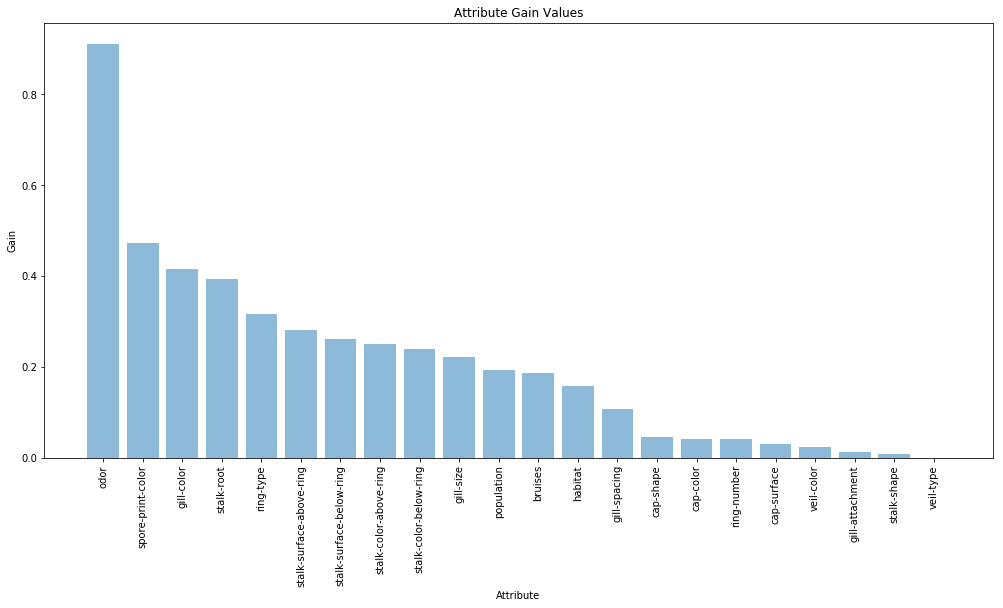

In [26]:
num_rows = len(train_df)
gain = {}
full_entropy = entropy(train_df)

# Calculate information gain for each attribute
for attribute in train_df.columns.values[1:]:
    value_counts = train_df[attribute].value_counts()
    attr_entropy = 0
    # Sum up entropy contributions of each value taken by the attribute
    for val in value_counts.index:
        val_ent = entropy(train_df[train_df[attribute] == val])
        attr_entropy = attr_entropy + (value_counts[val]/num_rows) * val_ent
    # Store information gain from splitting on the attribute
    gain[attribute] = full_entropy - attr_entropy

# Sort gain and turn into lists for plotting
sorted_gain = sorted(gain.items(), key=itemgetter(1), reverse = True)
list_gains = list(map(list, zip(*sorted_gain)))

attributes = list_gains[0]
y_pos = np.arange(len(attributes))
gains = list_gains[1]

# Plot chart
fig = plt.figure(figsize=(17,8))
plt.bar(y_pos, gains, align='center', alpha=0.5)
plt.xticks(y_pos, attributes, rotation = 'vertical')
plt.ylabel('Gain')
plt.xlabel('Attribute')
plt.title('Attribute Gain Values')
plt.show()
plt.close()

From this chart, we can see that *odor* will be a very important split; and that it is a good indicator of edibility. The higher information gain of an attribute, the more important it will be to our classifiers. One of many ways we can visualize this trend is by plotting counts of edible and poisonous mushrooms classified by their attribute categories:

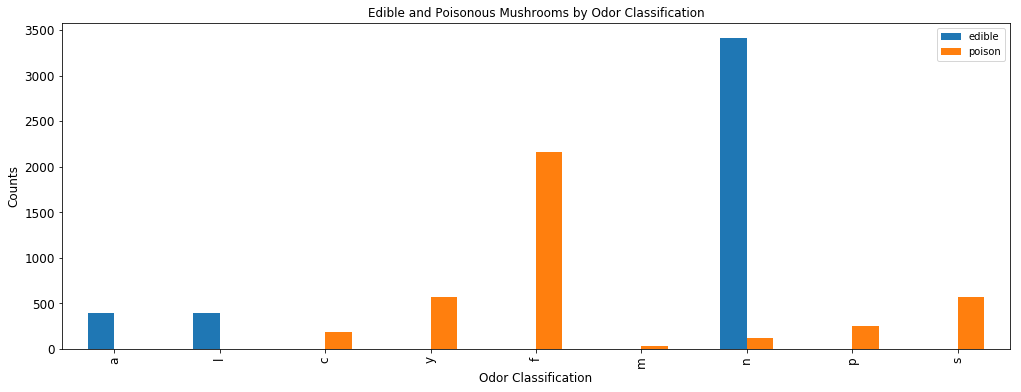

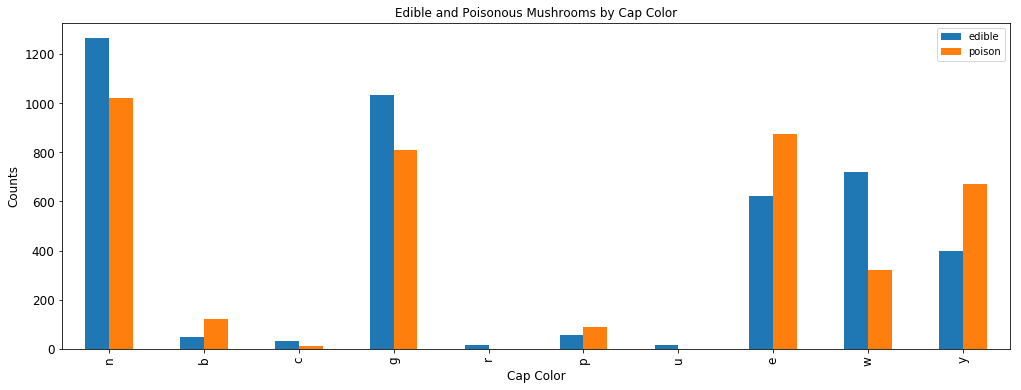

In [27]:
# Create new dataframes to hold counts
counts_odor_df = pd.DataFrame(index=odor, columns=['edible','poison'])
counts_color_df = pd.DataFrame(index=cap_color, columns=['edible','poison'])

# Populate counts from original dataframe
for c in odor:
    counts_odor_df.ix[c, 'edible'] = len(shrooms_df[(shrooms_df['class']=='e') & (shrooms_df['odor']==c)])
    counts_odor_df.ix[c, 'poison'] = len(shrooms_df[(shrooms_df['class']=='p') & (shrooms_df['odor']==c)])

for c in cap_color:
    counts_color_df.ix[c, 'edible'] = len(shrooms_df[(shrooms_df['class']=='e') & (shrooms_df['cap-color']==c)])
    counts_color_df.ix[c, 'poison'] = len(shrooms_df[(shrooms_df['class']=='p') & (shrooms_df['cap-color']==c)])

# Plot bar graph comparison for odor
ax = counts_odor_df.plot(kind='bar', title ="Edible and Poisonous Mushrooms by Odor Classification", \
                         figsize=(17, 6), legend=True, fontsize=12)
ax.set_xlabel("Odor Classification", fontsize=12)
ax.set_ylabel("Counts", fontsize=12)
plt.show()
plt.close()

# Plot bar graph comparison for cap color
ax = counts_color_df.plot(kind='bar', title ="Edible and Poisonous Mushrooms by Cap Color", \
                         figsize=(17, 6), legend=True, fontsize=12)
ax.set_xlabel("Cap Color", fontsize=12)
ax.set_ylabel("Counts", fontsize=12)
plt.show()
plt.close()

These somewhat-awkward grouped bar graphs illustrate how neatly mushrooms can be classified as 'edible' or 'poisonous' by their odor (most odor categories correspond to only edible or only poisonous mushrooms), and conversely how cap color is almost never a certain predictor of edibility (most cap color categories can apply to a comparable number of edible and poisonous mushrooms).

# III. Machine Learning

## Decision Trees

The first classifier we're going to look at is a decision tree.

<a href='http://scikit-learn.org/stable/modules/tree.html'>Decision trees</a> are "a non-parametric supervised learning method used for classification".

As a sample, let us initialize sklearn's DecisionTreeClassifier with a max_depth of 3. After initialization, let us fit our training data and export the decision tree to an image.

In [28]:
y_train = encoded_train['class']
x_train = encoded_train[list(encoded_train.columns[1:])]

decision_tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3) # min_samples_split=20, random_state=99)
decision_tree.fit(x_train, y_train)

with open("assets/dt.dot", 'w') as f:
    export_graphviz(decision_tree, out_file = f, feature_names=encoded_train.columns[1:])
    f.close()
    
with open("assets/dt.dot", 'r') as f:
    temp = f.read()
    s = Source(temp, filename="assets/dt", format="png")
    s.render(cleanup = True) # Save as png file
    f.close()

<img src="assets/dt.png" height="600" width="600">

As we can see, each node of the decision tree shows how many samples are at the node before branching. There are other information such as entropy and its branching feature. 

## K-Fold Cross Validation

One tricky thing about decision trees is determining the depth of the tree. If we let the tree grow for too much, we may run into <a href='https://en.wikipedia.org/wiki/Overfitting'>overfitting</a> our data. Overfitting may cause our decision tree classifier to do poorly when it comes to predicting test data because the classifier lose generality.

One way to search for a optimal depth is to do a k-fold cross-validation with a range of max_depths to choose from. In a k-fold cross-validation, the data is split into k subsets so that k-1 subsets are used for testing and 1 subset is used for testing. 

By using <a href='http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html'>GridSearchCV</a>, we can do both a k-fold cross validation and also test different depth parameters.

In [29]:
def k_fold_cv (X, Y, classifier, param_grid, cv):
    grid_search = GridSearchCV(classifier, param_grid=param_grid, cv=cv)
    grid_search.fit(X,Y)
    return grid_search

def get_top_n_scores(grid_scores, n):
    top_n_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n]
    for i, score in enumerate(top_n_scores):
        print("Rank: " + str(i + 1))
        print("Mean Test score: " + str(score.mean_validation_score))
        print("Max-Depth: " + str(score.parameters) + "\n")
    
param_grid = {"max_depth": np.array(range(1, len(train_df.columns[1:])))}
dt_classifier = DecisionTreeClassifier()
grid_search = k_fold_cv(x_train, y_train, dt_classifier, param_grid, cv = 10)

get_top_n_scores(grid_search.grid_scores_, 5)

Rank: 1
Mean Test score: 0.9998153618906942
Max-Depth: {'max_depth': 8}

Rank: 2
Mean Test score: 0.9998153618906942
Max-Depth: {'max_depth': 9}

Rank: 3
Mean Test score: 0.9998153618906942
Max-Depth: {'max_depth': 10}

Rank: 4
Mean Test score: 0.9998153618906942
Max-Depth: {'max_depth': 11}

Rank: 5
Mean Test score: 0.9998153618906942
Max-Depth: {'max_depth': 12}



After running our grid search, we can see that a max_depth of 8 produced the most accurate predictions with a .99815 accuracy. Here below, we can see how our decision tree with max_depth set to 8.

In [30]:
decision_tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 8)
decision_tree.fit(x_train, y_train)

with open("assets/optimal.dot", 'w') as f:
    export_graphviz(decision_tree, out_file = f, feature_names=encoded_train.columns[1:])
    f.close()
    
with open("assets/optimal.dot", 'r') as f:
    temp = f.read()
    s = Source(temp, filename="assets/optimal", format="png")
    s.render(cleanup = True) # Save as png file
    f.close()

<img src="assets/optimal.png" height="600" width="600">

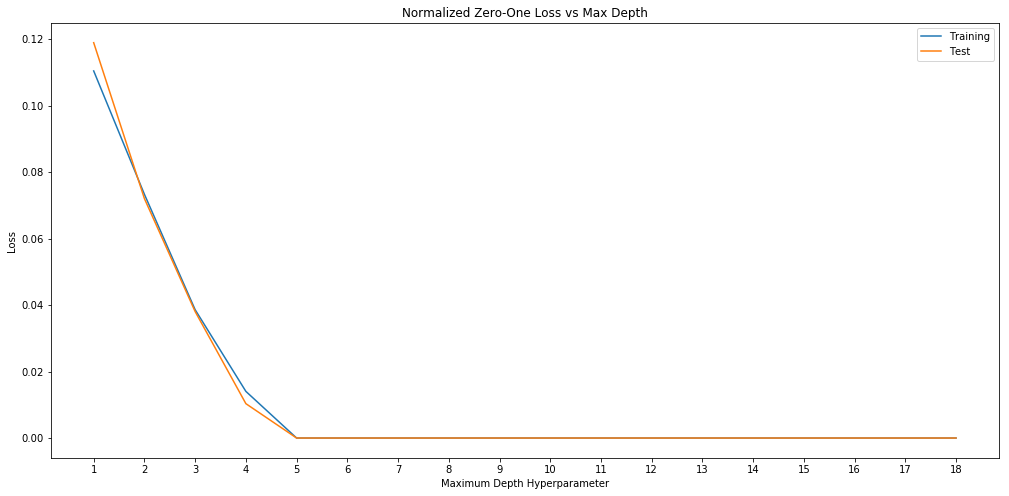

In [31]:
# Retrieve training data again
y_train = encoded_train['class']
x_train = encoded_train[list(encoded_train.columns[1:])]

# Encode and split test set
encoded_test = pd.get_dummies(test_df, \
                               columns = list(test_df.columns.values)[1:])
y_test = encoded_test['class']
x_test = encoded_test[list(encoded_test.columns[1:])]

# Dictionaries to store loss for model on training and test data
loss = {'training': {}, 'test': {}}

# Get training and test loss for each max depth hyperparameter
for i in np.array(range(1, len(train_df.columns[1:20]))):
    decision_tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = i)
    decision_tree.fit(x_train, y_train)
    train_predict = decision_tree.predict(x_train)
    test_predict = decision_tree.predict(x_test)
    loss['training'][i] = zero_one_loss(y_train, train_predict)
    loss['test'][i] = zero_one_loss(y_test, test_predict)

# Plot loss as a function of max depth
fig = plt.figure(figsize=(17,8))
y_pos = np.array(range(1, len(train_df.columns[1:20])))
train_line, = plt.plot(list(loss['training'].keys()), list(loss['training'].values()), label = "Training")
test_line, = plt.plot(list(loss['test'].keys()), list(loss['test'].values()), label = "Test")
plt.xticks(y_pos, y_pos)
plt.ylabel('Loss')
plt.xlabel('Maximum Depth Hyperparameter')
plt.title('Normalized Zero-One Loss vs Max Depth')
plt.legend(handles=[train_line, test_line])
plt.show()

By varying the maximum depth of the decision tree classifier as our model complexity hyperparameter, we observe the expected behavior of training loss decreasing with increase in complexity. However, the model appears to be robust to the perils of overfitting, as the loss in the test error also decreases to a negligible value with increasing complexity and does not increase afterward.

According the rankings of the optimal depths obtained above, it would appear that each of the trials generated with max depth paramter greater than or equal to 8 resulted in identical trees, indicating that an optimal depth with no further necessary splits was reached within 8 steps. Those 8 splits appear to generalize very well, as practically no loss is experienced in the test set as well.

## Support Vector Machines
Now, let's generate a support vector classification for edibility of mushrooms. This is very simple now that we've already separated our data into training and testing sets.

[Support Vector Machines](#https://en.wikipedia.org/wiki/Support_vector_machine) are also supervised learning models which, given an input, classify it into discrete categories. SVMs are particularly useful when performing a binary classification, as we are here (**p/e**). They work by finding the hyperplane that splits the two classes with the largest margin. We will be using scikit-learn's [svm.SVC class](#http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

First, initialize your classification and fit the training data:

In [32]:
# Initialize Support Vector Classification
svc = svm.SVC(kernel='linear')
# Fit the support vector machine model according to the training set
svc.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Scikit does all of the work. If you just want to view the results, you can feed the test data straight into svc's `predict` function and receive an array of p/e classifications.

In [33]:
# Perform classifications on sample
print(svc.predict(x_test))

['e' 'p' 'p' ..., 'e' 'e' 'e']


As you might expect, this class will also calculate the accuracy of the classification given the results of test data:

In [34]:
# Return the mean accuracy on given test data and labels 
score = svc.score(x_test, y_test)
print("SVC accuracy: ", score*100)

SVC accuracy:  100.0


The support vector machine we have created has an accuracy of 100% for our test data, which isn't much of a surprise after the results of our decision tree and given that we know at least one of the features — odor — is a very good predictor of edibility. Unfortunately, because we have split our features using the one-hot encoding, and because the features themselves were categorical to begin with, there isn't an especially useful way to visualize this split (we certainly can't display the hyperplane in all of its dimensions).

# IV. Conclusion

Based on our test results, we can see that our machine learning classifiers can determine a mushroom's edibility quite accurately. We're excited to continue learning about data science and we hope to solve more real-world problems. 

Thank you, <a href='http://jpdickerson.com/'>Professor John Dickerson</a> for teaching us data science and igniting new interests.